# Operator generation with PyTTN

Import libraries

In [1]:
import numpy as np
import time
import sys
import h5py
import scipy
import copy
from numba import jit
import matplotlib.pyplot as plt 
%matplotlib inline

Import PyTTN dependencies

In [2]:
from pyttn import *

# Function to visualise tree diagrams
from pyttn.utils import visualise_tree

### Contents



1. [Defining operators](#defining-operators)

    - [Specifying mode types](#specifying-mode-types)

    - [Basic operator definition](#basic-operator-definition)

    - [Advanced operator definition](#advanced-operator-definition)

2. [Spin operators](#spin-operators)

    - [Example Hamiltonian: 1-D transverse-field Ising model](#example-hamiltonian-transverse-field-ising-model)

3. [Fermionic operators](#fermionic-operators)

    - [Example Hamiltonian: 1-D Kitaev chain](#example-hamiltonian-1-dimensional-kitaev-chain)

4. [Two-level system operators](#two-level-system-operators)

    - [Example Hamiltonian: Rabi oscillations & time-dependent coefficients](#example-hamiltonian-rabi-oscillations--time-dependent-coefficients)

5. [Bosonic operators](#bosonic-operators)

    - [Example Hamiltonian: 1-D Bose-Hubbard model](#example-hamiltonian-1-dimensional-bose-hubbard-model)

6. [Constructing a Tree Tensor Network Operator](#constructing-a-tree-tensor-network-operator)

7. [Custom operators & generic modes](#custom-operators--generic-modes)

8. [Global operators](#global-operators)

9. [Mode combination](#mode-combination)

### Defining operators

##### Specifying mode types

To initialise the system, the physical modes are created through the function `system_modes`. The information about the modes of the system is stored in the variable `sysinf`.

In [3]:
# Number of modes
N = 5

# Initialise system information variable as a set of N modes
sysinf = system_modes(N)

After creating the modes, one needs to specify the type of each mode. PyTTN accepts five different modes:

- _d_-dimensional spin systems
- Two-level systems
- Bosons
- Fermions
- User-defined generic modes

The code will store the information about the modes and automatically understand e.g. if a certain $\hat{a}^{\dagger}$ is a bosonic or fermionic creation operator depending on which mode it acts on.

As an example below, we will set each mode to be of a different kind. The dimension of the Hilbert space of the spin, bosonic, and generic mode are set in the argument of the function.

In [4]:
sysinf[0] = spin_mode(2)
sysinf[1] = boson_mode(10)
sysinf[2] = fermion_mode()
sysinf[3] = tls_mode()
sysinf[4] = generic_mode(3)

There is more information on each type of mode and their predefined operators in the sections below.

##### Basic operator definition

Once the information about the modes is specified, one can start applying operators that act on these modes.

A **site operator** is initialised as a `sOP` object (which stands for _"site OPerator"_). The `sOP()` function takes two arguments: the first one, a string label selecting which operator to apply; the second one, the physical index of the degree of freedom in which the operator acts.

For example, to apply a Pauli $\hat{\sigma}_x$ on the two-level system at mode `3`, one would write:

In [5]:
sOP("x",3)

Similarly, to apply a bosonic creation operator $\hat{a}^{\dagger}$ on site `1`, one would write:

In [6]:
sOP("adag",1)

A fermionic operator is defined in the same way. Since the type of mode is defined in `sysinf`, the code will automatically determine if `"a"` refers to a bosonic or fermionic annihilation operator $\hat{a}$. Below is an example of the annihilation operator acting on the bosonic mode on site `1`, and on the fermionic mode on site `2`.

To avoid coding confusion with bosonic operators, it is possible to define fermionic modes using the function `fOP`, which stands for _"fermionic OPerator"_. This option is purely redundant since the information about the modes is stored on `sysinf`, but can provide a useful visual clue about the nature of the modes when coding.

In [7]:
# Bosonic annihilation operator (acts on mode 1: a boson)
sOP("a",1)

# Fermionic annihilation operator (acts on mode 2: a fermion)
sOP("a",2)

# Exactly the same fermionic annihilation operator
fOP("a",2)

The site operators `sOP` can be multiplied normally using `*` to create composite operators that act on several modes. The resulting operator is a `sPOP` object—a _"site Product of OPerators"_. 

In [8]:
sOP("adag",1)*fOP("adag",2)

A `sPOP` can also be created directly from a list of operators. This can be useful when defining operators acting on many modes.

In [9]:
# Imagine a set of 20 modes
M = 20

# Define a list containing number operators acting on each mode
ops = []
for i in range(M):
    ops.append(sOP("n",i))

# The product of all those number operators: n_1 * n_2 * n_3 * ...
sPOP(ops)

To add site operators `sOP` (and products of site operators `sPOP`) together, one defines a `SOP` object. This is very useful when defining Hamiltonians and other nontrivial operators.

To allocate memory efficiently, the `SOP` object needs to be initialised with a defined number of modes. The `sOP` and `sPOP` operators are then added using `+=`. They can be added alone, multiplied to each other, and multiplied to coefficients.

The resulting operator can be printed as a string for easy visualisation.

In [10]:
# Initialise a SOP object with N modes
H = SOP(N)

# Adding site operators to SOP in different ways
H += sOP("z",0)
H += sOP("y",0)*sOP("adag",1)
H += -0.5*sOP("x",0)*fOP("a",2)
H += (-1.5 + 3j)*sOP("x",3)*sOP("n",1)
H += sPOP([sOP("x",3),sOP("y",3),sOP("z",3)])

# Print SOP as string of operators
print(H)

((0,0) + 0 functions)
+((1,0) + 0 functions) x_3 y_3 z_3
((-1.5,3) + 0 functions) n_1 x_3
((-0.5,0) + 0 functions) x_0 fermi_a_2
+((1,0) + 0 functions) y_0 adag_1
+((1,0) + 0 functions) z_0



##### Advanced operator definition

The above sections should be enough to understand most of this tutorial. However, there are some more relevant features that could be useful for the advanced user. This section will cover:

- The _string N-Body Operator_ and the `coefficient`class
- Time-dependent coefficients
- Product of Hamiltonians

**The _string N-Body Operator_ and the `coefficient` class**

In the section above explained the `sPOP` (_string Product of OPerators_) was introduced as the product of site operators `sOP`. Indeed, if one multiplies two `sOP` together, the resulting object is a `sPOP`:

In [11]:
sOP("adag",1)*fOP("adag",2)

However, multiplying a scalar times a string of site operators does not result in a `sPOP`, but rather a slightly different object called `sNBO`: a _string N-Body Operator_.

In [12]:
(0.5+1j) * sOP("adag",1)*fOP("adag",2)

This is related to how PyTTN processes coefficients. Every coefficient that multiplies a _site OPerator_ `sOP` or a _site Product of OPerators_ `sPOP` is processed as a `coefficient` object. A `sNBO` is simply a `sPOP` multiplied by a `coefficient` type object.

When a scalar multiplies a site operator, this processing is done internally, and the user does not need to worry about initialising the scalar as a `coefficient`. However, when the coefficient is a function, it needs to be initialised explicitly as a `coefficient` object using the `coeff()` function. 

In [13]:
coeff(0.5+1j) * sOP("adag",1)*fOP("adag",2)

**Time-dependent coefficients**

The possibility of using callable functions as coefficients allows for the use of time-dependent coefficients.

Any function that is callable as `__call__(t:float) -> float / complex` can be configured as a `coefficient` object. This means a time-dependent coefficient could be as simple as this:

In [14]:
coeff(lambda t: np.exp(-t)) * sOP("z", 0) 

or a much more elaborate callable object:

In [15]:
class transf:
    # Initialise internal parameters
    def __init__(self, i:int, t0:float, e0:float, U0:np.matrix, conj = False):
        self.i = i
        self.conj = conj
        self.t0 = t0
        self.e = copy.deepcopy(e0)
        self.U = copy.deepcopy(U0)

    # Update to the coefficient value
    def __call__(self, ti):
        evol = np.conj(self.U[:, 0])@(np.exp(-1.0j*ti*self.e)*self.U[:, self.i])
        val = self.t0 * evol

        if(self.conj):
            val = np.conj(val)

        return val

# Set value of parameters 
t0 = 1.0
e = 2.0
U = np.random.random((4,4))

# Apply time-dependent coefficient
coeff(transf(2, t0, e, U, conj=False)) * sOP("z", 0)

Note: when calculating dynamics of time-dependent Hamiltonians using TDVP, it is important to set the parameter `sweep.use_time_dependent_hamiltonian = True`. When turned off, the time evolution will be calculated using the Hamiltonian at $t=0$.

**Product of Hamiltonians**

The section [above](#basic-operator-definition) explained how to define _site operators_ `sOP`; how to multiply them to obtain _site product of operators_ `sPOP`; and how to add several `sOP` and `sPOP` together to generate _sums of operators_ `SOP`. 

`SOP` objects are used to construct Hamiltonians, and encode the information about its site operators in a memory efficient way—that is also the reason why a `SOP` needs to be initialised for a specific number of modes.

In [16]:
# Initialise Hamiltonian as SOP ("Sum of OPerators") object with N modes
H = SOP(2)

# Add terms to the Hamiltonian
H += sOP("x",0)
H += sOP("z",1)

# Print as string of operators
print(H)

((0,0) + 0 functions)
+((1,0) + 0 functions) z_1
+((1,0) + 0 functions) x_0



However, these memory restrictions also mean that it is not possible to multiply two `SOP` and obtain a new `SOP`:

In [17]:
H2 = H*H

TypeError: unsupported operand type(s) for *: 'pyttn.ttnpp.SOP_complex' and 'pyttn.ttnpp.SOP_complex'

For that purpose, one may use a simpler class: `sSOP`, a _string Sum of OPerators_. A `sSOP` simply combines site operators `sOP` and `sPOP` to create complex operators, without regard for memory allocation. It is how `SOP` processes site operators internally before allocating memory efficiently. It is not created for a fixed number of modes, and can be multiplied times other `sSOP` to create new `sSOP`.

Because it is not as optimised, its use is discouraged when not needed. For the same reason, a `sSOP` cannot be used to construct a Tree Tensor Network Operator, and instead must be converted to a `SOP` for that purpose.

Besides the differences in memory allocation, sums of operators using `sSOP` work exactly like with `SOP`:

In [18]:
# Initialise Hamiltonian as sSOP ("string Sum of OPerators")
# without a set number of modes
Hsop = sSOP()

# Add terms to the Hamiltonian
Hsop += sOP("x",0)
Hsop += sOP("z",1)

# Print as string of operators
print(Hsop)

+((1,0) + 0 functions) x_0
+((1,0) + 0 functions) z_1



And it can be observed that `sSOP` objects can be multiplied by other `sSOP` objects:

In [19]:
Hsop2 = Hsop*Hsop

# Print as string of operators
print(Hsop2)

+((1,0) + 0 functions) x_0 x_0
+((1,0) + 0 functions) x_0 z_1
+((1,0) + 0 functions) z_1 x_0
+((1,0) + 0 functions) z_1 z_1



The resulting Hamiltonian is also a `sPOP`. To construct a Tree Tensor Network Operator from it, it is necessary to transform it to a `SOP`:

In [20]:
# Initialise Hamiltonian as SOP object
H2 = SOP(N)

# Add elements of sSOP to SOP
for el in Hsop2:
    H2 += el

# Print as string of operators
print(H2)

((0,0) + 0 functions)
+((1,0) + 0 functions) z_1 z_1
+((2,0) + 0 functions) x_0 z_1
+((1,0) + 0 functions) x_0 x_0



### Spin operators

The _d_-dimensional spin modes have several predefined operators that commonly appear in spin systems. Below is a list of these operators and the labels that can be used to call them.

- Raising operator $\hat{S}^+$: `s+`, `sp`.

- Lowering operator $\hat{S}^-$: `s-`,`sm`.

- $\hat{S}^x = \frac{1}{2}(\hat{S}^+ + \hat{S}^-)$: `sx`, `x`.

- $\hat{S}^y = \frac{-i}{2}(\hat{S}^+ - \hat{S}^-)$: `sy`, `y`.

- $\hat{S}^z = \frac{-i}{\hbar}[\hat{S}^x, \hat{S}^y]$: `sz`, `z`.

The dimension of the spin operators is automatically adapted to the dimension set in the `spin_mode`.

One can also define other custom operators—more information on this in the section [Custom operators & generic modes](#custom-operators--generic-modes).

##### Example Hamiltonian: transverse-field Ising model

As an example of a spin system, we construct the 1-dimensional transverse-field Ising model.

The Hamiltonian of the model is: $\hat{H} = -J \sum_{j=1}^{N-1} \hat{S}^z_j \hat{S}^z_{j+1} - h \sum_j^N \hat{S}^x_j$

To construct the Hamiltonian of the system, the first step is to initialise the modes:

In [21]:
# Define number of modes
N = 10

# Initialise system information variable as a set of N modes
sysinf = system_modes(N)

# Specify that each mode is a 2-dimensional spin
for i in range(N):
    sysinf[i] = spin_mode(2)

Then, one can specify the parameters of the Hamiltonian:

In [22]:
J = 4
h = 2

And construct the Hamiltonian:

In [23]:
# Initialise H as SOP object ("Sum of OPerators")
H = SOP(N)

# Add terms of Hamiltonian
for i in range(N-1):
    H += -J*sOP("sz",i)*sOP("sz",i+1)
    H += -h*sOP("sx",i)
H += -h*sOP("sx",N-1)

# Print Hamiltonian as string of operators
print(H)

((0,0) + 0 functions)
((-4,0) + 0 functions) sz_8 sz_9
((-2,0) + 0 functions) sx_9
((-2,0) + 0 functions) sx_8
((-2,0) + 0 functions) sx_7
((-2,0) + 0 functions) sx_6
((-4,0) + 0 functions) sz_0 sz_1
((-2,0) + 0 functions) sx_5
((-2,0) + 0 functions) sx_0
((-4,0) + 0 functions) sz_1 sz_2
((-2,0) + 0 functions) sx_1
((-2,0) + 0 functions) sx_2
((-4,0) + 0 functions) sz_3 sz_4
((-2,0) + 0 functions) sx_3
((-4,0) + 0 functions) sz_7 sz_8
((-4,0) + 0 functions) sz_4 sz_5
((-2,0) + 0 functions) sx_4
((-4,0) + 0 functions) sz_5 sz_6
((-4,0) + 0 functions) sz_2 sz_3
((-4,0) + 0 functions) sz_6 sz_7



Once the Hamiltonian is constructed in this form, it can be initialised as a Tree Tensor Network Operator, aware of the topology of the network and able to interact as an operator with a Tree Tensor Network. This is explained step by step in the section [Constructing a Tree Tensor Network Operator](#constructing-a-tree-tensor-network-operator).

### Fermionic operators

The predefined operators for fermionic modes are listed below. They can be called with any of the labels indicated, undistinguishably.

- Annihilation operator $\hat{a}$: `a`, `c`, `f`.

- Creation operator $\hat{a}^{\dagger}$: `adag`, `ad`, `cdag`, `cd`, `fdag`, `fd`.

- Number operator $\hat{n} = \hat{a}^{\dagger}\hat{a}$: `n`, `adaga`, `ada`, `cdagc`, `cdc`, `fdagf`, `fdf`.

- Vacancy operator $\hat{v} = \mathbb{\hat{I}} - \hat{n} = \hat{a}\hat{a}^{\dagger}$: `v`.

One can also define other custom operators—more information on this in the section [Custom operators & generic modes](#custom-operators--generic-modes).

Fermionic operators are particular because they obey anti-commutation relations. In order to be implemented in a tensor network, they need to be mapped to operators that the tensor network can handle effectively. The Jordan-Wigner maps are commonly used for this purpose: they map the fermionic creation and annihilation operators to spin operators. In PyTTN, this transformation is done internally, so the user does not have to worry about applying Jordan-Wigner maps to the predefined fermionic operators. This should, however, be considered when defining custom operators.

##### Example Hamiltonian: 1-dimensional Kitaev chain

As an example of a fermionic system, we construct the 1-dimensional Kitaev chain.

The Hamiltonian of the model is: $\hat{H} = -\mu \sum_{j=1}^{N} \hat{a}^{\dagger}_j \hat{a}_j  - t \sum_{j=1}^{N-1} \left( \hat{a}^{\dagger}_j \hat{a}_{j+1} + \hat{a}^{\dagger}_{j+1} \hat{a}_j \right) + \Delta \left( \hat{a}^{\dagger}_{j} \hat{a}^{\dagger}_{j+1} + \hat{a}_j \hat{a}_{j+1} \right)$.

To construct the Hamiltonian of the system, the first step is to initialise the modes:

In [24]:
# Define number of modes
N = 10

# Initialise system information variable as a set of N modes
sysinf = system_modes(N)

# Specify that each mode is a fermion
for i in range(N):
    sysinf[i] = fermion_mode()

One can then specify the parameters of the Hamiltonian:

In [25]:
mu = 1.5
t = 2.
delta = 10

And construct the Hamiltonian:

In [26]:
# Initialise H as SOP object ("Sum of OPerators")
H = SOP(N)

# Add terms of Hamiltonian
for i in range(N-1):
    H += -t*(sOP("fdag",i)*sOP("f",i+1) + sOP("fdag",i+1)*sOP("f",i))
    H += delta*(sOP("fdag",i)*sOP("fdag",i+1) + sOP("f",i+1)*sOP("f",i))

for i in range(N):
    H += -mu*sOP("n",i)

# Print Hamiltonian as string of operators
print(H)

((0,0) + 0 functions)
((-1.5,0) + 0 functions) n_9
((-1.5,0) + 0 functions) n_8
((-1.5,0) + 0 functions) n_7
((-1.5,0) + 0 functions) n_4
((-1.5,0) + 0 functions) n_1
+((10,0) + 0 functions) fdag_8 fdag_9
((-1.5,0) + 0 functions) n_5
((-2,0) + 0 functions) f_8 fdag_9
+((10,0) + 0 functions) f_7 f_8
+((10,0) + 0 functions) fdag_7 fdag_8
((-2,0) + 0 functions) f_7 fdag_8
((-2,0) + 0 functions) f_2 fdag_3
+((10,0) + 0 functions) f_6 f_7
((-2,0) + 0 functions) fdag_7 f_8
+((10,0) + 0 functions) fdag_1 fdag_2
((-1.5,0) + 0 functions) n_6
((-2,0) + 0 functions) fdag_1 f_2
+((10,0) + 0 functions) fdag_2 fdag_3
+((10,0) + 0 functions) f_5 f_6
+((10,0) + 0 functions) f_0 f_1
((-1.5,0) + 0 functions) n_2
+((10,0) + 0 functions) f_2 f_3
((-2,0) + 0 functions) fdag_2 f_3
+((10,0) + 0 functions) f_4 f_5
((-1.5,0) + 0 functions) n_0
+((10,0) + 0 functions) f_8 f_9
((-2,0) + 0 functions) f_0 fdag_1
((-2,0) + 0 functions) f_1 fdag_2
((-2,0) + 0 functions) fdag_8 f_9
((-2,0) + 0 functions) f_6 fdag_7
+

Once the Hamiltonian is constructed in this form, it can be initialised as a Tree Tensor Network Operator, aware of the topology of the network and able to interact as an operator with a Tree Tensor Network. This is explained step by step in the section [Constructing a Tree Tensor Network Operator](#constructing-a-tree-tensor-network-operator).

### Two-Level System operators

Two-level-system modes are similar to 2-dimensional spin modes. Rather than using the spin operators, their operations are given by Pauli matrices—one must be careful with the scaling factor between the 2-dimensional $\hat{S}_+$ and the Pauli matrix $\hat{\sigma}_x$.

The predefined operators for two-level systems are listed below, along with the labels that can be used to call them.

- Pauli $\hat{\sigma}^x$: `x`, `sigmax`.

- Pauli $\hat{\sigma}^y$: `y`, `sigmay`.

- Pauli $\hat{\sigma}^z$: `z`, `sigmaz`.

- Raising operator $\hat{\sigma}^+ = \hat{\sigma}^x + i\hat{\sigma}^y$: `s+`, `sigma+`, `sp`, `sigmap`.

- Lowering operator $\hat{\sigma}^- = \hat{\sigma}^x - i\hat{\sigma}^y$: `s-`,`sigma-`, `sm`, `sigmam`.

One can also define other custom operators—more information on this in the section [Custom operators & generic modes](#custom-operators--generic-modes).

##### Example Hamiltonian: Rabi oscillations & time-dependent coefficients

As an example of a two-level system Hamiltonian, we model the dynamics of a two-level atom undergoing Rabi oscillations.

The Hamiltonian of the system is: $\hat{H} = \frac{\hbar \omega_0}{2} \hat{\sigma}^z + \hbar \Omega \text{cos}(\omega t) \hat{\sigma}^x$.

To construct the Hamiltonian of the system, the first step is to initialise the modes:

In [27]:
# Define number of modes
N = 1

# Initialise system information variable as a set of N modes
sysinf = system_modes(N)

# Specify that each mode is a 2-dimensional spin
for i in range(N):
    sysinf[i] = tls_mode()

One can then specify the parameters of the Hamiltonian:

In [28]:
w_0 = 1
w = 2
Rabi_freq = 5

And the final step is to construct the Hamiltonian. This Hamiltonian has time-dependent coefficients, which makes it different to the example Hamiltonian above. To construct it, recall [how coefficients are processed in PyTTN](#advanced-operator-definition):

> Every coefficient that multiplies a _site OPerator_ `sOP` or a _site Product of OPerators_ `sPOP` is processed as a `coefficient` object. When a scalar multiplies a site operator, this processing is done internally, and the user does not need to worry about initialising the scalar as a `coefficient`. However, when the coefficient is a time-dependent function, it needs to be initialised as a `coefficient` object using the `coeff()` function. Any function that is callable as `__call__(t:float) -> float / complex` can be configured as a `coefficient` object.

Note: when calculating dynamics of time-dependent Hamiltonians using TDVP, it is important to set the parameter `sweep.use_time_dependent_hamiltonian = True`. When turned off, the time evolution will be calculated using the $t=0$ Hamiltonian.

Therefore, the Hamiltonian of a two-level atom under Rabi oscillations can be constructed as follows:

In [29]:
# Initialise H as SOP object ("Sum of OPerators")
H = SOP(N)

# Add terms of Hamiltonian
H += w_0/2*sOP("z",0)
H += Rabi_freq*coeff(lambda t: np.cos(w*t))*sOP("x", 0) 

# Print Hamiltonian as string of operators
print(H)

((0,0) + 0 functions)
+((0,0) + 1 functions) x_0
+((0.5,0) + 0 functions) z_0



Once the Hamiltonian is constructed in this form, it can be initialised as a Tree Tensor Network Operator, aware of the topology of the network and able to interact as an operator with a Tree Tensor Network. This is explained step by step in the section [Constructing a Tree Tensor Network Operator](#constructing-a-tree-tensor-network-operator).

### Bosonic operators

The predefined operators for bosonic modes are listed below. They can be called with any of the labels indicated, undistinguishably.

- Annihilation operator $\hat{a}$: `a`, `c`, `b`.

- Creation operator $\hat{a}^{\dagger}$: `adag`, `ad`, `cdag`, `cd`, `bdag`, `bd`.

- Number operator $\hat{n} = \hat{a}^{\dagger}\hat{a}$: `n`, `adaga`, `ada`, `cdagc`, `cdc`, `bdagb`, `bdb`.

- Position operator $\hat{x} = \frac{1}{\sqrt{2}} \left( \hat{a}^{\dagger} + \hat{a} \right)$: `x`, `q`.

- Momentum operator $\hat{p} = \frac{i}{\sqrt{2}} \left( \hat{a}^{\dagger} - \hat{a} \right)$: `p`.

The dimension of the bosonic operators is automatically adapted to the dimension set in the `boson_mode`.

One can also define other custom operators—more information on this in the section [Custom operators & generic modes](#custom-operators--generic-modes).

##### Example Hamiltonian: 1-dimensional Bose-Hubbard model

As an example of a bosonic system, we construct the Hamiltonian of the 1-dimensional Bose-Hubbard model.

The Hamiltonian of the system is: $\hat{H} = -t \sum_{j=1}^{N-1} \left( \hat{a}^{\dagger}_j \hat{a}_{j+1} + \hat{a}_{j} \hat{a}^{\dagger}_{j+1} \right) + \frac{U}{2} \sum_j \hat{n}_j(\hat{n}_j - 1) - \mu \sum_j \hat{n}_j$.

To construct the Hamiltonian of the system, the first step is to initialise the modes:

In [30]:
# Define number of modes
N = 10

# Initialise system information variable
sysinf = system_modes(N)

# Specify that each mode is a boson, with a Hilbert space of 15 energy levels
for i in range(N):
    sysinf[i] = boson_mode(15)

One can then specify the parameters of the Hamiltonian:

In [31]:
t = 0.2
U = 5.
mu = -1.5

And construct the Hamiltonian:

In [32]:
# Initialise H as SOP object ("Sum of OPerators")
H = SOP(N)

# Add terms of Hamiltonian
for i in range(N-1):
    H += -t*(sOP("bdag",i)*sOP("b",i+1) + sOP("bdag",i+1)*sOP("b",i))

for i in range(N):
    H += -mu*sOP("n",i)
    H += U/2*(sOP("n",i)*sOP("n",i)-sOP("n",i))

# Print Hamiltonian as string of operators
print(H)

((0,0) + 0 functions)
+((2.5,0) + 0 functions) n_9 n_9
((-1,0) + 0 functions) n_9
+((2.5,0) + 0 functions) n_8 n_8
((-1,0) + 0 functions) n_8
+((2.5,0) + 0 functions) n_7 n_7
+((2.5,0) + 0 functions) n_6 n_6
((-1,0) + 0 functions) n_7
+((2.5,0) + 0 functions) n_5 n_5
((-0.2,0) + 0 functions) b_5 bdag_6
((-0.2,0) + 0 functions) b_3 bdag_4
+((2.5,0) + 0 functions) n_0 n_0
((-0.2,0) + 0 functions) b_7 bdag_8
((-0.2,0) + 0 functions) b_2 bdag_3
((-0.2,0) + 0 functions) bdag_6 b_7
((-0.2,0) + 0 functions) bdag_5 b_6
((-1,0) + 0 functions) n_6
((-0.2,0) + 0 functions) bdag_1 b_2
((-0.2,0) + 0 functions) bdag_4 b_5
((-1,0) + 0 functions) n_3
((-0.2,0) + 0 functions) bdag_3 b_4
((-0.2,0) + 0 functions) b_4 bdag_5
((-1,0) + 0 functions) n_0
((-0.2,0) + 0 functions) b_0 bdag_1
((-0.2,0) + 0 functions) b_1 bdag_2
((-0.2,0) + 0 functions) bdag_0 b_1
((-0.2,0) + 0 functions) b_6 bdag_7
((-0.2,0) + 0 functions) bdag_8 b_9
+((2.5,0) + 0 functions) n_2 n_2
((-1,0) + 0 functions) n_1
((-0.2,0) + 0 func

Once the Hamiltonian is constructed in this form, it can be initialised as a Tree Tensor Network Operator, aware of the topology of the network and able to interact as an operator with a Tree Tensor Network. This is explained step by step in the section [Constructing a Tree Tensor Network Operator](#constructing-a-tree-tensor-network-operator).

### Constructing a Tree Tensor Network Operator

The examples above have combined site operators to construct Hamiltonians that act on the modes specified in `sysinf`. However, the Hamiltonian in that form cannot be applied to a Tree Tensor Network: a `SOP` object is not aware of the topology of the network, and thus cannot act as an operator on the TTN.

Thus in order to initialise the Hamiltonian as a Tree Tensor Network Operator (a TTNO), it will be necessary to define a network topology `topo`, and create the Tree Tensor Network that the TTNO will act on. 

In this example we will write a binary (degree = 2) ML-MCTDH tree. For a detailed explanation of how to construct the tree topology, read [tree_topologies.ipynb](file/../tree_topologies.ipynb).

ntree : (1(8(8(8(8(2))(8(2)))(8(2)))(8(8(2))(8(2))))(8(8(8(8(2))(8(2)))(8(2)))(8(8(2))(8(2)))));



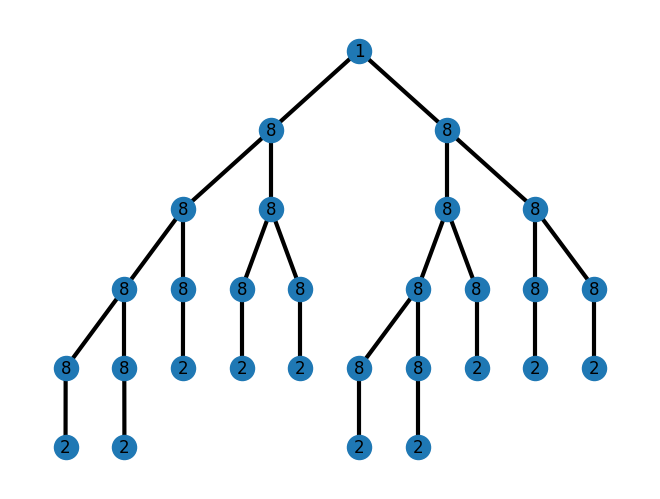

In [33]:
# Specify parameters of the tree
chi = 8
dims = [2 for i in range(N)]
degree = 2

# Create tree topology
topo = ntreeBuilder.mlmctdh_tree(dims, degree, chi)
print(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

The Tree Tensor Network is created using the `ttn` function. To be created, the TTN only needs to know the topology of the network, previously defined in `topo`. For simplicity, in the example below it is initialised to a random value.

The function that creates a Tree Tensor Network Operator is `sop_operator`. It takes three arguments:
- the Hamiltonian defined as a combination of site operators.
- the Tree Tensor Network (which internally has the information about the network topology in `topo`).
- the information about the physical modes and their dimensionality, stored in the variable `sysinf`.

In [34]:
# Create tree tensor network, initialise to random value
A = ttn(topo)
A.random()

# Initialise Hamiltonian as a TTNO (Tree Tensor Network Operator)
h = sop_operator(H, A, sysinf)

((0,0) + 0 functions)
+((2.5,0) + 0 functions) n_9 n_9
((-1,0) + 0 functions) n_9
+((2.5,0) + 0 functions) n_8 n_8
((-1,0) + 0 functions) n_8
+((2.5,0) + 0 functions) n_7 n_7
+((2.5,0) + 0 functions) n_6 n_6
((-1,0) + 0 functions) n_7
+((2.5,0) + 0 functions) n_5 n_5
((-0.2,0) + 0 functions) b_5 bdag_6
((-0.2,0) + 0 functions) b_3 bdag_4
+((2.5,0) + 0 functions) n_0 n_0
((-0.2,0) + 0 functions) b_7 bdag_8
((-0.2,0) + 0 functions) b_2 bdag_3
((-0.2,0) + 0 functions) bdag_6 b_7
((-0.2,0) + 0 functions) bdag_5 b_6
((-1,0) + 0 functions) n_6
((-0.2,0) + 0 functions) bdag_1 b_2
((-0.2,0) + 0 functions) bdag_4 b_5
((-1,0) + 0 functions) n_3
((-0.2,0) + 0 functions) bdag_3 b_4
((-0.2,0) + 0 functions) b_4 bdag_5
((-1,0) + 0 functions) n_0
((-0.2,0) + 0 functions) b_0 bdag_1
((-0.2,0) + 0 functions) b_1 bdag_2
((-0.2,0) + 0 functions) bdag_0 b_1
((-0.2,0) + 0 functions) b_6 bdag_7
((-0.2,0) + 0 functions) bdag_8 b_9
+((2.5,0) + 0 functions) n_2 n_2
((-1,0) + 0 functions) n_1
((-0.2,0) + 0 func

The Hamiltonian in `h` is a Tree Tensor Network Operator, ready to be used in tensor network algorithms.

### Custom operators & generic modes

The beginning of this tutorial listed the five types of modes that can be declared in `sysinf`: $d$-dimensional spin, two-level system, boson, fermion, and generic. The sections above have explored the first four types of modes; this section looks at the fifth type, generic modes.

Generic modes are $d$-dimensional modes whose operators are defined by the user, usually by their matrix representation. Generic modes have no predefined operators and can be of any dimension set by the user.

In the example below we define a system of 2 modes: a 2-dimensional generic mode and a two-level system.

In [35]:
# Define number of modes
N = 2

# Initialise system information variable
sysinf = system_modes(N)

# Specify type of modes. It is important to specify the dimension of the generic mode
sysinf[0] = generic_mode(2)
sysinf[1] = tls_mode()

The user-defined operators are stored in an operator dictionary, created with the function `operator_dictionary`. For efficient use of memory, it must be created for a specific number of modes.

To create an operator, the first step is to define a complex matrix with the same dimension as the generic mode. The function `site_operator` creates the operator from its matrix representation. It is important to specify that the argument of the function is a matrix by setting the option `"optype=matrix"`.

Finally, the newly-created operator is added to the operator dictionary. In this step, it is important to specify the mode on which the operator acts, and the string label that will be used to call the operator.

In [36]:
# Create custom operator dictionary for N modes
opdict = operator_dictionary(N)


## Define custom operator on generic mode

# Create matrix of an operator
v = np.zeros( (2,2), dtype=np.complex128)
v[0, 0] = 1.0

# Define operator acting on mode 0 from matrix v
op =  site_operator(v, optype="matrix", mode=0)

# Add created operator to the dictionary, specifying that it acts on mode 0
# and assigning the label "|0><0|" to it
opdict.insert(0, "|0><0|", op)


## Define another custom operator on generic mode

# Create matrix of an operator
v = np.zeros( (2,2), dtype=np.complex128)
v[1, 1] = 1.0

# Define operator acting on mode 0 from matrix v
op =  site_operator(v, optype="matrix", mode=0)

# Add created operator to the dictionary, specifying that it acts on mode 0
# and assigning the label "|1><1|" to it
opdict.insert(0, "|1><1|", op)


# View custom operator dictionary
print(opdict)

mode: 0
|1><1| dense matrix operator: 
[[0+0i, 0+0i],
[0+0i, 1+0i]]


|0><0| dense matrix operator: 
[[1+0i, 0+0i],
[0+0i, 0+0i]]


mode: 1



The user-defined operators can be called using their labels, exactly as all the predefined operators:

In [37]:
sOP("|0><0|",0)

Significantly, the user can also define custom operators for other modes, so they are not restricted to the set of predefined operators. Custom operators are defined just like operators of generic modes—one must only remember to specify the correct mode that the operator acts on. Custom operators can be stored in the same operator dictionary as operators of generic modes. Below is an example of a user-defined `"Hadamard"` operator that acts on mode `1`, a two-level system.

If a custom operator is assigned the same label as a predefined operator of the mode it acts on, it overwrites that operator. For example, the code below defines a `"z"` operator for the two-level system that conflicts with the predefined $\hat{\sigma}^z$ operator, which can also be called with the `"z"` label. In this situation, the code will always apply the user-defined operator over the predefined one.

In [38]:
## Define custom operator on two-level system mode

# Create matrix of an operator
v = np.zeros( (2,2), dtype=np.complex128)
v[0, 0] = 1.0/np.sqrt(2)
v[0, 1] = 1.0/np.sqrt(2)
v[1, 0] = 1.0/np.sqrt(2)
v[1, 1] = -1.0/np.sqrt(2)

# Define operator acting on mode 1 from matrix v
op =  site_operator(v, optype="matrix", mode=1)

# Add created operator to the dictionary, specifying that it acts on mode 1
# and assigning the label "Hadamard" to it
opdict.insert(1, "Hadamard", op)


## Overwrite existing "z" operator on generic mode

# Create matrix of an operator
v = np.zeros( (2,2), dtype=np.complex128)
v[0, 0] = 1.0
v[1, 1] = -1.0

# Define operator acting on mode 1 from matrix v
op =  site_operator(v, optype="matrix", mode=1)

# Add created operator to the dictionary, specifying that it acts on mode 1
# and assigning the label "z" to it
opdict.insert(1, "z", op)

print(opdict)

mode: 0
|1><1| dense matrix operator: 
[[0+0i, 0+0i],
[0+0i, 1+0i]]


|0><0| dense matrix operator: 
[[1+0i, 0+0i],
[0+0i, 0+0i]]


mode: 1
z dense matrix operator: 
[[1+0i, 0+0i],
[0+0i, -1+0i]]


Hadamard dense matrix operator: 
[[0.707107+0i, 0.707107+0i],
[0.707107+0i, -0.707107+0i]]





The user-defined operators can be used to construct Hamiltonians exactly as predefined operators:

In [39]:
# Initialise H as SOP object ("Sum of OPerators")
H = SOP(N)

# Add terms of Hamiltonian
H += sOP("|0><0|",0)
H += sOP("|1><1|",0)
H += sOP("Hadamard",1)
H += sOP("z",1)

# Print Hamiltonian as string of operators
print(H)

((0,0) + 0 functions)
+((1,0) + 0 functions) z_1
+((1,0) + 0 functions) Hadamard_1
+((1,0) + 0 functions) |1><1|_0
+((1,0) + 0 functions) |0><0|_0



There is one important change one has to remember when defining custom operators. When defining the Tree Tensor Network Operator as [above](#constructing-a-tree-tensor-network-operator) using the function `sop_operator`, the code takes the matrix representation of all the operators and constructs an operator aware of the topology of the Tree Tensor Network, that can be contracted with the TTN and used in tensor network algorithms. 

To use the matrix representation of the user-defined operators, the function `sop_operator` takes the operator dictionary as an optional fourth argument. 

The code below constructs the network topology and the Tree Tensor Network using the code in the section [above](#constructing-a-tree-tensor-network-operator)—both are necessary to initialise the Hamiltonian as a Tree Tensor Network Operator.

ntree : (1(8(2))(8(2)));



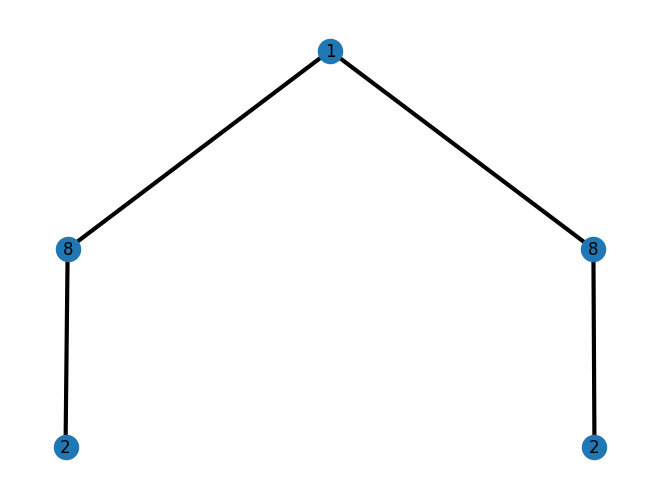

In [40]:
# Specify parameters of the tree
chi = 8
dims = [2 for i in range(N)]
degree = 2

# Create tree topology
topo = ntreeBuilder.mlmctdh_tree(dims, degree, chi)
print(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

# Create tree tensor network, initialise to random value
A = ttn(topo)
A.random()

Having created the Tree Tensor Network with the network topology in `topo`, the Tree Tensor Network Operator of the Hamiltonian can be created. The function `sop_operator` takes now four arguments:
- the Hamiltonian defined as a combination of site operators.
- the Tree Tensor Network (which internally has the information about the network topology in `topo`).
- the information about the physical modes and their dimensionality, stored in the variable `sysinf`.
- (optional, but needed for user-defined operators) the dictionary of user-defined operators and the modes they act on.

In [41]:
h = sop_operator(H, A, sysinf, opdict)

((0,0) + 0 functions)
+((1,0) + 0 functions) z_1
+((1,0) + 0 functions) Hadamard_1
+((1,0) + 0 functions) |1><1|_0
+((1,0) + 0 functions) |0><0|_0



### Global operators

Besides creating TTNOs from Hamiltonians, one may also want to create simple operators to apply to the state, or calculate expectation values and matrix elements. This is much simpler than creating TTNOs [as described above](#constructing-a-tree-tensor-network-operator), and can be done in a single step.

Consider the system above, with one generic mode and one two-level system, and the custom operators defined there:

In [42]:
print(sysinf)

( generic mode (2) ) ( tls mode (2) ) 


To create a one-site operator, one only needs the site operator `sOP` object and the information about the modes contained in `sysinf`. 

The function `site_operator` combines them to create an operator that can be directly used to perform operations with the TTN:

In [43]:
site_operator(sOP("x", 1), sysinf)

If the operator used is user-defined, it is also necessary to include the operator dictionary that stores the definitions of the operators:

In [44]:
# User-defined operator on generic mode at site 0
site_operator(sOP("|0><0|", 0), sysinf, opdict)

# User defined operator on two-level system mode at site 1
site_operator(sOP("Hadamard", 1), sysinf, opdict)

A simple many-body operator can also be created from a site product of operators `sPOP` using the function `product_operator`. Again, when using user-defined operators, it is necessary to include the operator dictionary:

In [45]:
# Vector of site operators
ops = [sOP("|1><1|",0), sOP("z",1), sOP("x",1)]

sPOP(ops)

# Create product operator from sPOP
product_operator(sPOP(ops), sysinf, opdict)

One may realise that these operators are created without including `topo`, the information about the topology of the network. This is because `topo` is already contained in the TTN, and thus when the operators are applied to the TTN they automatically take the information about the network to perform the calculation:

In [46]:
# Define one-body operator
op = site_operator(sOP("x", 1), sysinf)

# Apply to TTN defined in previous section
B = A.apply_one_body_operator(op)

There is a detailed explanation on performing operations with TTNs in the corresponding tutorial.

### Mode combination

Another powerful feature of PyTTN is the possibility to define composite modes, that is, modes that encode more than one degree of freedom per site.

This is very useful to study the entanglement structure between subsystems of a system with many degrees of freedom. The modes that interact strongly, forming a subsystem, can be grouped together to define a composite mode. Composite modes can then be addressed globally as a single effective degree of freedom in the TTN.

The physical modes can still be addressed individually when defining site operators and Hamiltonians. Essentially, nothing changes between using mode combination and not using it when building the Hamiltonian or any other operator. The advantage is that, by using a reduced number of modes in the tensor network, the entanglement between subsystems (i.e. between the composite modes) is described more efficiently.

The example below shows a list of dimensions corresponding to 10 physical modes. They are easily combined into composite modes using nested lists. The modes that are combined have to be adjacent: only modes next to each other in the network can form a composite mode—this is to avoid closed loops in the network topology.

In [47]:
# Vector with the dimensions of the modes
modes = [40, 32, 20, 12, 8, 4, 8, 24, 24, 8]

# Grouping adjacent modes into composite modes
composite_modes = [[0, 1], [2, 3, 4], [5, 6, 7], [8, 9]]

# Number of composite modes
Nm = len(composite_modes)

When defining the system information, the composite modes are defined as a list of physical modes. In the example below, the physical modes are bosons with a number of energy levels specified in the vector `modes` above. The first composite mode will be a list containing two bosonic modes with dimensions `40` and `32`, respectively, and so on.

The dimension of the composite modes is calculated as the product of the dimension of the physical modes, using the function `lhd()`—which stands for _local Hilbert dimension_.

In [48]:
# Vector to store dimensions of composite modes
comp_modes_dims = []

# Initialise system information variable
sysinf = system_modes(Nm)

for ind, comb in enumerate(composite_modes):
    # Define each composite mode as a list of adjacent bosonic modes, 
    # whose dimensions are defined in the vector 'modes'
    sysinf[ind] = [boson_mode(modes[x]) for x in comb]

    # Store the Local Hilbert Dimension (LHD) of the composite modes
    comp_modes_dims.append(sysinf[ind].lhd())

# Print dimensions of composite modes
print(comp_modes_dims)


[1280, 1920, 768, 192]


The topology of the network is adapted to contain only the composite modes. In the example below, note that the resulting network only has 4 leaves instead of the 10 that would correspond to the physical degrees of freedom. In systems with a large number of degrees of freedom, mode combination can mean a drastic reduction in the size of the network.

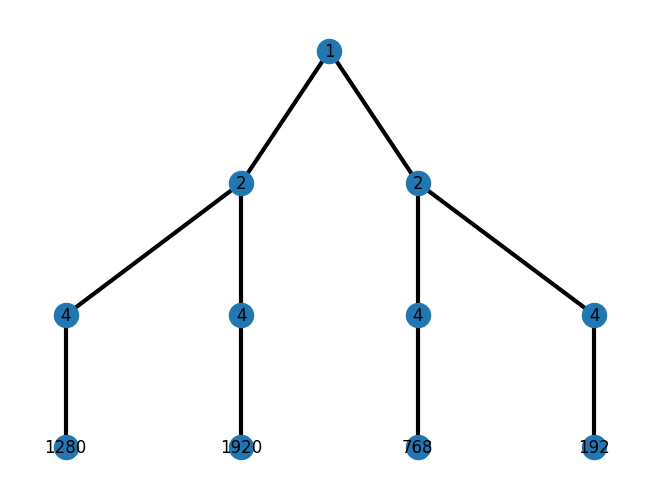

In [49]:
# Seed  of the tree diagram
topo = ntree("(1(2(4)(4))(2(4)(4)))")

# Insert a new node, with the dimension of a composite mode,
# at the end of each basis node
topo()[0][0].insert(comp_modes_dims[0])
topo()[0][1].insert(comp_modes_dims[1])
topo()[1][0].insert(comp_modes_dims[2])
topo()[1][1].insert(comp_modes_dims[3])

# Plot tree diagram
visualise_tree(topo)
plt.show()

The physical modes are still addressed individually when creating Hamiltonians and other operators. 

As an example, let's set up a Hamiltonian for the 10 bosonic modes, with couplings between those modes that form each composite mode: 

$\hat{H} = \sum_j^N \varepsilon_j \hat{n}_j + \delta_0 \left( \hat{n}_0 \hat{n}_1 + \hat{a}^{\dagger}_0 \hat{a}^{}_1 \right) + \delta_1 \left( \hat{n}_2 \hat{n}_3 \hat{n}_4 + \hat{a}^{}_2 \hat{a}^{\dagger}_3 \hat{a}^{}_4 \right) + \delta_2 \left( \hat{n}_5 \hat{n}_6 \hat{n}_7 + \hat{a}^{}_5 \hat{a}^{\dagger}_6 \hat{a}^{}_7 \right) + \delta_3 \left( \hat{n}_8 \hat{n}_9 + \hat{a}^{\dagger}_8 \hat{a}^{}_9 \right)$.

We will initialise the coeficients $\varepsilon_j$ and $\delta_j$ randomly:

In [50]:
# Number of physical modes
N = len(modes)

# Parameters of the Hamiltonian
eps = [np.random.randn() for _ in range(N)]
delta = [np.random.randn() for _ in range(Nm)]

And set up the Hamiltonian:

In [51]:
# Initialise H as SOP object ("Sum of OPerators")
H = SOP(N)

# Add terms of Hamiltonian
for i in range(N):
    H += eps[i]*sOP("n",i)

for i in range(Nm):
    H += delta[i]*sPOP([sOP("n",index) for index in composite_modes[i]])
H += delta[0]*sOP("adag",0)*sOP("a",1)
H += delta[1]*sOP("a",2)*sOP("adag",3)*sOP("a",4)
H += delta[2]*sOP("a",5)*sOP("adag",6)*sOP("a",7)
H += delta[3]*sOP("adag",8)*sOP("a",9)

# Print Hamiltonian as string of operators
print(H)

((0,0) + 0 functions)
+((0.435049,0) + 0 functions) adag_8 a_9
+((0.907626,0) + 0 functions) a_2 adag_3 a_4
((-0.05034,0) + 0 functions) adag_0 a_1
+((0.435049,0) + 0 functions) n_8 n_9
((-0.641895,0) + 0 functions) n_0
+((0.30113,0) + 0 functions) n_1
((-0.05034,0) + 0 functions) n_0 n_1
((-0.208971,0) + 0 functions) n_2
+((1.08695,0) + 0 functions) a_5 adag_6 a_7
+((1.78849,0) + 0 functions) n_3
+((0.0432789,0) + 0 functions) n_6
+((0.219193,0) + 0 functions) n_4
+((0.907626,0) + 0 functions) n_2 n_3 n_4
((-0.597455,0) + 0 functions) n_5
+((0.630611,0) + 0 functions) n_7
((-0.958569,0) + 0 functions) n_8
+((0.122212,0) + 0 functions) n_9
+((1.08695,0) + 0 functions) n_5 n_6 n_7



With this, the final step is to create the TTN and initialise the Tree Tensor Network Operator using the function `sop_operator`. The TTNO is aware of the topology of the network, and the nature of the composite modes.

In [52]:
# Create tree tensor network, initialise to random value
A = ttn(topo)
A.random()

# Initialise Hamiltonian as a TTNO (Tree Tensor Network Operator)
h = sop_operator(H, A, sysinf)

((0,0) + 0 functions)
+((0.435049,0) + 0 functions) adag_8 a_9
+((0.907626,0) + 0 functions) a_2 adag_3 a_4
((-0.05034,0) + 0 functions) adag_0 a_1
+((0.435049,0) + 0 functions) n_8 n_9
((-0.641895,0) + 0 functions) n_0
+((0.30113,0) + 0 functions) n_1
((-0.05034,0) + 0 functions) n_0 n_1
((-0.208971,0) + 0 functions) n_2
+((1.08695,0) + 0 functions) a_5 adag_6 a_7
+((1.78849,0) + 0 functions) n_3
+((0.0432789,0) + 0 functions) n_6
+((0.219193,0) + 0 functions) n_4
+((0.907626,0) + 0 functions) n_2 n_3 n_4
((-0.597455,0) + 0 functions) n_5
+((0.630611,0) + 0 functions) n_7
((-0.958569,0) + 0 functions) n_8
+((0.122212,0) + 0 functions) n_9
+((1.08695,0) + 0 functions) n_5 n_6 n_7

